# Checkpoint Comparison: Diffusion vs Transformer

This notebook compares two checkpoints trained with different architectures:
1. **Diffusion Model** (`GETRegionDiffusion`): DiT-style diffusion transformer
2. **Transformer Model** (`GETRegionPretrain`): Base GET transformer model

Both were trained with the same settings on the PBMC dataset. We'll evaluate both on the same validation set and compare their performance.


In [40]:
import sys
import os

# Add project root to Python path
PROJECT_ROOT = '/home/yoyomanzoor/Documents/get_multimodel'
if PROJECT_ROOT not in sys.path:
    sys.path.insert(0, PROJECT_ROOT)
os.chdir(PROJECT_ROOT)


In [41]:
# Create results directory if it doesn't exist
RESULTS_DIR = 'results'
os.makedirs(RESULTS_DIR, exist_ok=True)
print(f"Results will be saved to: {os.path.abspath(RESULTS_DIR)}")


Results will be saved to: /home/yoyomanzoor/Documents/get_multimodel/results


In [42]:
import torch
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from scipy import stats
from tqdm import tqdm

from get_model.config.config import load_config_from_yaml, export_config
from get_model.run_region import RegionLitModel, RegionZarrDataModule

# Set style
plt.rcParams['figure.dpi'] = 100
plt.rcParams['font.family'] = 'sans-serif'
sns.set_style('whitegrid')


## Define Checkpoint Paths


In [43]:
# Checkpoint paths
CHECKPOINT_DIFFUSION = os.path.expanduser("~/greatlakes/diffusion-best-v1.ckpt")
CHECKPOINT_TRANSFORMER = os.path.expanduser("~/greatlakes/transformer-best-v1.ckpt")

# Check if checkpoints exist
print(f"Diffusion checkpoint exists: {os.path.exists(CHECKPOINT_DIFFUSION)}")
print(f"Transformer checkpoint exists: {os.path.exists(CHECKPOINT_TRANSFORMER)}")


Diffusion checkpoint exists: True
Transformer checkpoint exists: True


## Load Configuration


In [44]:
# Load configs for both models
from get_model.config.config import load_config

# Config for Diffusion model (GETRegionDiffusion from diffusion.py)
cfg_diffusion = load_config_from_yaml("tutorials/yamls/dit.yaml")
cfg_diffusion.stage = 'validate'
cfg_diffusion.run.use_wandb = False
cfg_diffusion.machine.num_workers = 2
cfg_diffusion.machine.batch_size = 8
# Don't load pretrained checkpoint when evaluating the diffusion checkpoint
cfg_diffusion.finetune.checkpoint = None
cfg_diffusion.finetune.resume_ckpt = None

# Config for Transformer model (GETRegionPretrain from model.py)
cfg_transformer = load_config('pretrain_tutorial')
cfg_transformer.model = load_config('model/GETRegionPretrain').model.model
cfg_transformer.stage = 'validate'
cfg_transformer.run.use_wandb = False
cfg_transformer.machine.num_workers = 2
cfg_transformer.machine.batch_size = 8
cfg_transformer.dataset.mask_ratio = 0.5
cfg_transformer.dataset.zarr_path = cfg_diffusion.dataset.zarr_path
cfg_transformer.dataset.leave_out_celltypes = cfg_diffusion.dataset.leave_out_celltypes
cfg_transformer.dataset.celltypes = cfg_diffusion.dataset.celltypes
# Don't load pretrained checkpoint when evaluating the transformer checkpoint
cfg_transformer.finetune.checkpoint = None
cfg_transformer.finetune.resume_ckpt = None

print("=== Diffusion Model Config ===")
print(f"Model type: {cfg_diffusion.model._target_}")
print(f"Dataset: {cfg_diffusion.dataset.zarr_path}")
print(f"Leave-out celltypes: {cfg_diffusion.dataset.leave_out_celltypes}")
print(f"Pretrained checkpoint: {cfg_diffusion.finetune.checkpoint}")

print("\n=== Transformer Model Config ===")
print(f"Model type: {cfg_transformer.model._target_}")
print(f"Dataset: {cfg_transformer.dataset.zarr_path}")
print(f"Leave-out celltypes: {cfg_transformer.dataset.leave_out_celltypes}")
print(f"Pretrained checkpoint: {cfg_transformer.finetune.checkpoint}")


=== Diffusion Model Config ===
Model type: get_model.model.diffusion.GETRegionDiffusion
Dataset: /home/yoyomanzoor/Crucial/get_data/annotation_dir/pbmc10k_multiome.zarr
Leave-out celltypes: cd8_tem_1
Pretrained checkpoint: None

=== Transformer Model Config ===
Model type: get_model.model.model.GETRegionPretrain
Dataset: /home/yoyomanzoor/Crucial/get_data/annotation_dir/pbmc10k_multiome.zarr
Leave-out celltypes: cd8_tem_1
Pretrained checkpoint: None


## Helper Functions


In [45]:
def compute_metrics(preds, obs):
    """
    Compute various metrics for the predictions.
    """
    # Flatten if needed
    preds_flat = preds.flatten()
    obs_flat = obs.flatten()
    
    # Remove any NaN values
    valid_idx = ~(np.isnan(preds_flat) | np.isnan(obs_flat))
    preds_flat = preds_flat[valid_idx]
    obs_flat = obs_flat[valid_idx]
    
    metrics = {
        'pearson': stats.pearsonr(preds_flat, obs_flat)[0],
        'spearman': stats.spearmanr(preds_flat, obs_flat)[0],
        'mse': np.mean((preds_flat - obs_flat) ** 2),
        'mae': np.mean(np.abs(preds_flat - obs_flat)),
        'r2': 1 - np.sum((obs_flat - preds_flat) ** 2) / np.sum((obs_flat - np.mean(obs_flat)) ** 2),
        'n_samples': len(preds_flat)
    }
    
    return metrics


def evaluate_model_on_dataloader(model, dataloader, device='cuda'):
    """
    Run evaluation and collect predictions vs observations.
    """
    model.eval()
    model = model.to(device)
    
    all_preds = []
    all_obs = []
    
    with torch.no_grad():
        for batch in tqdm(dataloader, desc="Evaluating"):
            # Move batch to device
            batch = {k: v.to(device) if isinstance(v, torch.Tensor) else v 
                     for k, v in batch.items()}
            
            # Get model input
            model_input = model.model.get_input(batch)
            
            # Forward pass
            output = model.model(**model_input)
            
            # Get predictions and observations
            pred, obs = model.model.before_loss(output, batch)
            
            # Store results (handle masked key)
            for key in pred:
                all_preds.append(pred[key].cpu().numpy())
                all_obs.append(obs[key].cpu().numpy())
    
    # Concatenate all results
    all_preds = np.concatenate(all_preds, axis=0)
    all_obs = np.concatenate(all_obs, axis=0)
    
    return all_preds, all_obs


## Create DataLoader


In [46]:
# Create data modules for both models (they use the same dataset, but we need separate DMs for the configs)
dm_diffusion = RegionZarrDataModule(cfg_diffusion)
dm_diffusion.setup(stage='validate')

dm_transformer = RegionZarrDataModule(cfg_transformer)
dm_transformer.setup(stage='validate')

# Get validation dataloaders
val_dataloader_diffusion = dm_diffusion.val_dataloader()
val_dataloader_transformer = dm_transformer.val_dataloader()

print(f"Diffusion model - Number of validation batches: {len(val_dataloader_diffusion)}")
print(f"Transformer model - Number of validation batches: {len(val_dataloader_transformer)}")


100%|██████████| 1/1 [00:00<00:00, 12.08it/s]


Leave out chromosomes: []
Input chromosomes: ['chr1', 'chr2', 'chr3', 'chr4', 'chr5', 'chr6', 'chr7', 'chr8', 'chr9', 'chr10', 'chr11', 'chr12', 'chr13', 'chr14', 'chr15', 'chr16', 'chr17', 'chr18', 'chr19', 'chr20', 'chr21', 'chr22', 'chrX']


100%|██████████| 1/1 [00:00<00:00, 122.57it/s]

Leave out chromosomes: ['chr11']
Input chromosomes: ['chr11']
Diffusion model - Number of validation batches: 79
Transformer model - Number of validation batches: 5


## Load and Evaluate Diffusion Model (GETRegionDiffusion)


In [47]:
print("Loading Diffusion Model (GETRegionDiffusion)...")

# Load diffusion checkpoint using Lightning's load_from_checkpoint
try:
    model_diffusion = RegionLitModel.load_from_checkpoint(
        CHECKPOINT_DIFFUSION,
        cfg=cfg_diffusion,
        strict=False
    )
    model_diffusion.eval()
    print("Diffusion model loaded successfully!")
    
    # Evaluate
    print("Evaluating Diffusion Model...")
    device = 'cuda' if torch.cuda.is_available() else 'cpu'
    preds_diffusion, obs_diffusion = evaluate_model_on_dataloader(model_diffusion, val_dataloader_diffusion, device=device)
    metrics_diffusion = compute_metrics(preds_diffusion, obs_diffusion)
    
    print("\nDiffusion Model Metrics:")
    for k, v in metrics_diffusion.items():
        if isinstance(v, float):
            print(f"  {k}: {v:.4f}")
        else:
            print(f"  {k}: {v}")
            
except Exception as e:
    print(f"Error loading Diffusion Model: {e}")
    import traceback
    traceback.print_exc()
    preds_diffusion, obs_diffusion, metrics_diffusion = None, None, None


Loading Diffusion Model (GETRegionDiffusion)...


/home/yoyomanzoor/Crucial/get/lib/python3.12/site-packages/lightning/pytorch/utilities/migration/utils.py:56: The loaded checkpoint was produced with Lightning v2.6.0, which is newer than your current Lightning version: v2.5.6


Diffusion model loaded successfully!
Evaluating Diffusion Model...


Evaluating: 100%|██████████| 79/79 [00:04<00:00, 17.83it/s]



Diffusion Model Metrics:
  pearson: 0.7960287928581238
  spearman: 0.5890
  mse: 0.0012508196523413062
  mae: 0.015512339770793915
  r2: 0.6313
  n_samples: 35771200


## Load and Evaluate Transformer Model (GETRegionPretrain)


In [48]:
print("Loading Transformer Model (GETRegionPretrain)...")

# Load transformer checkpoint
try:
    model_transformer = RegionLitModel.load_from_checkpoint(
        CHECKPOINT_TRANSFORMER,
        cfg=cfg_transformer,
        strict=False
    )
    model_transformer.eval()
    print("Transformer model loaded successfully!")
    
    # Evaluate
    print("Evaluating Transformer Model...")
    device = 'cuda' if torch.cuda.is_available() else 'cpu'
    preds_transformer, obs_transformer = evaluate_model_on_dataloader(model_transformer, val_dataloader_transformer, device=device)
    metrics_transformer = compute_metrics(preds_transformer, obs_transformer)
    
    print("\nTransformer Model Metrics:")
    for k, v in metrics_transformer.items():
        if isinstance(v, float):
            print(f"  {k}: {v:.4f}")
        else:
            print(f"  {k}: {v}")
            
except Exception as e:
    print(f"Error loading Transformer Model: {e}")
    import traceback
    traceback.print_exc()
    preds_transformer, obs_transformer, metrics_transformer = None, None, None


Loading Transformer Model (GETRegionPretrain)...
Transformer model loaded successfully!
Evaluating Transformer Model...


Evaluating: 100%|██████████| 5/5 [00:00<00:00, 14.57it/s]



Transformer Model Metrics:
  pearson: 0.7799976468086243
  spearman: 0.3817
  mse: 0.0023768306709825993
  mae: 0.03073028288781643
  r2: 0.6083
  n_samples: 1153225


## Compare Results


In [49]:
# Create comparison table
comparison_data = []

if metrics_diffusion is not None:
    comparison_data.append({
        'Model': 'Diffusion (GETRegionDiffusion)',
        'Architecture': 'DiT-style with timestep conditioning',
        'Pearson': metrics_diffusion['pearson'],
        'Spearman': metrics_diffusion['spearman'],
        'MSE': metrics_diffusion['mse'],
        'MAE': metrics_diffusion['mae'],
        'R²': metrics_diffusion['r2'],
        'N Samples': metrics_diffusion['n_samples']
    })

if metrics_transformer is not None:
    comparison_data.append({
        'Model': 'Transformer (GETRegionPretrain)',
        'Architecture': 'Standard transformer encoder',
        'Pearson': metrics_transformer['pearson'],
        'Spearman': metrics_transformer['spearman'],
        'MSE': metrics_transformer['mse'],
        'MAE': metrics_transformer['mae'],
        'R²': metrics_transformer['r2'],
        'N Samples': metrics_transformer['n_samples']
    })

if comparison_data:
    comparison_df = pd.DataFrame(comparison_data)
    print("\n" + "="*80)
    print("COMPARISON SUMMARY: Diffusion vs Transformer")
    print("="*80)
    display(comparison_df)
    
    # Print winner for each metric
    if len(comparison_data) == 2:
        print("\n📊 Performance Comparison:")
        for metric in ['Pearson', 'Spearman', 'R²']:
            diff_val = comparison_data[0][metric]
            trans_val = comparison_data[1][metric]
            winner = "Diffusion" if diff_val > trans_val else "Transformer"
            print(f"  {metric}: {winner} wins ({diff_val:.4f} vs {trans_val:.4f})")
        for metric in ['MSE', 'MAE']:
            diff_val = comparison_data[0][metric]
            trans_val = comparison_data[1][metric]
            winner = "Diffusion" if diff_val < trans_val else "Transformer"
            print(f"  {metric}: {winner} wins ({diff_val:.6f} vs {trans_val:.6f})")
else:
    print("No models were successfully loaded for comparison.")



COMPARISON SUMMARY: Diffusion vs Transformer


,Model,Architecture,Pearson,Spearman,MSE,MAE,R²,N Samples
0,Diffusion (GETRegionDiffusion),DiT-style with timestep conditioning,0.796029,0.588960,0.001251,0.015512,0.631310,35771200
1,Transformer (GETRegionPretrain),Standard transformer encoder,0.779998,0.381709,0.002377,0.030730,0.608295,1153225



📊 Performance Comparison:
  Pearson: Diffusion wins (0.7960 vs 0.7800)
  Spearman: Diffusion wins (0.5890 vs 0.3817)
  R²: Diffusion wins (0.6313 vs 0.6083)
  MSE: Diffusion wins (0.001251 vs 0.002377)
  MAE: Diffusion wins (0.015512 vs 0.030730)


## Visualization: Scatter Plots (Predicted vs Observed)


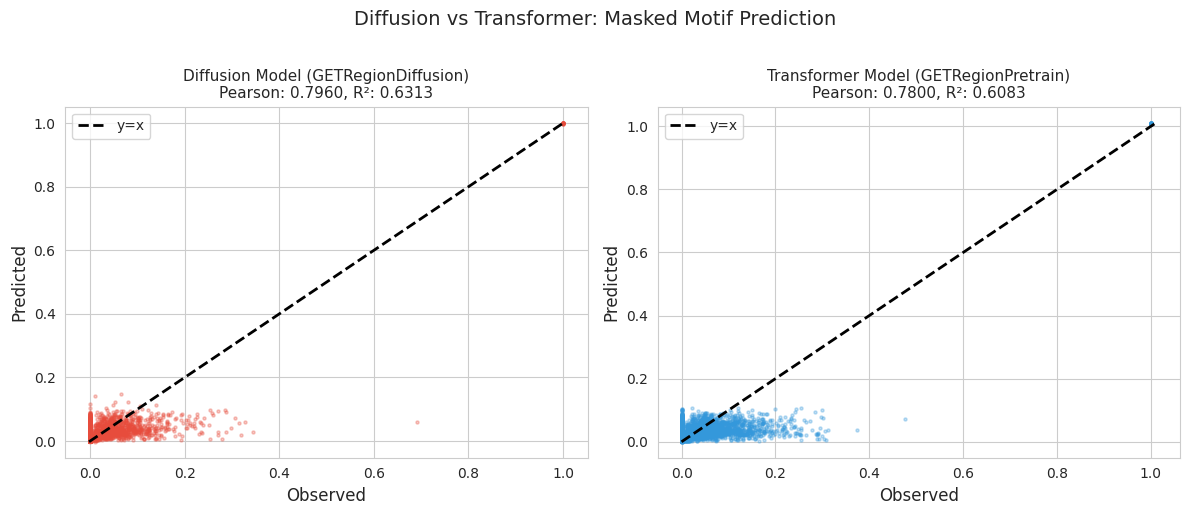

In [50]:
# Create scatter plots
fig, axes = plt.subplots(1, 2, figsize=(12, 5))

# Diffusion Model
ax = axes[0]
if preds_diffusion is not None and obs_diffusion is not None:
    # Subsample for visualization if too many points
    n_points = min(5000, len(preds_diffusion.flatten()))
    idx = np.random.choice(len(preds_diffusion.flatten()), n_points, replace=False)
    
    ax.scatter(obs_diffusion.flatten()[idx], preds_diffusion.flatten()[idx], 
               alpha=0.3, s=5, c='#e74c3c')
    
    # Add identity line
    lims = [min(obs_diffusion.flatten()[idx].min(), preds_diffusion.flatten()[idx].min()),
            max(obs_diffusion.flatten()[idx].max(), preds_diffusion.flatten()[idx].max())]
    ax.plot(lims, lims, 'k--', linewidth=2, label='y=x')
    
    ax.set_xlabel('Observed', fontsize=12)
    ax.set_ylabel('Predicted', fontsize=12)
    ax.set_title(f'Diffusion Model (GETRegionDiffusion)\nPearson: {metrics_diffusion["pearson"]:.4f}, R²: {metrics_diffusion["r2"]:.4f}', 
                 fontsize=11)
    ax.legend()
else:
    ax.text(0.5, 0.5, 'Diffusion model not loaded', 
             ha='center', va='center', fontsize=14, transform=ax.transAxes)
    ax.set_title('Diffusion Model')

# Transformer Model
ax = axes[1]
if preds_transformer is not None and obs_transformer is not None:
    n_points = min(5000, len(preds_transformer.flatten()))
    idx = np.random.choice(len(preds_transformer.flatten()), n_points, replace=False)
    
    ax.scatter(obs_transformer.flatten()[idx], preds_transformer.flatten()[idx], 
               alpha=0.3, s=5, c='#3498db')
    
    lims = [min(obs_transformer.flatten()[idx].min(), preds_transformer.flatten()[idx].min()),
            max(obs_transformer.flatten()[idx].max(), preds_transformer.flatten()[idx].max())]
    ax.plot(lims, lims, 'k--', linewidth=2, label='y=x')
    
    ax.set_xlabel('Observed', fontsize=12)
    ax.set_ylabel('Predicted', fontsize=12)
    ax.set_title(f'Transformer Model (GETRegionPretrain)\nPearson: {metrics_transformer["pearson"]:.4f}, R²: {metrics_transformer["r2"]:.4f}', 
                 fontsize=11)
    ax.legend()
else:
    ax.text(0.5, 0.5, 'Transformer model not loaded', 
             ha='center', va='center', fontsize=14, transform=ax.transAxes)
    ax.set_title('Transformer Model')

plt.suptitle('Diffusion vs Transformer: Masked Motif Prediction', fontsize=14, y=1.02)
plt.tight_layout()
plt.savefig(f'{RESULTS_DIR}/diffusion_vs_transformer_scatter.png', dpi=150, bbox_inches='tight')
plt.show()


## Distribution Comparison


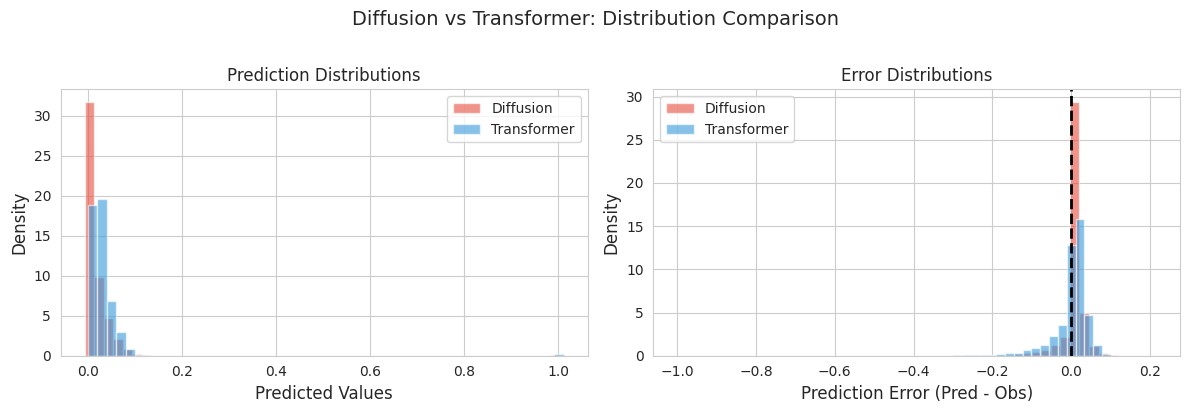

In [51]:
# Compare prediction and error distributions
fig, axes = plt.subplots(1, 2, figsize=(12, 4))

# Prediction distributions
ax = axes[0]
if preds_diffusion is not None:
    ax.hist(preds_diffusion.flatten(), bins=50, alpha=0.6, label='Diffusion', 
            color='#e74c3c', density=True)
if preds_transformer is not None:
    ax.hist(preds_transformer.flatten(), bins=50, alpha=0.6, label='Transformer', 
            color='#3498db', density=True)
ax.set_xlabel('Predicted Values', fontsize=12)
ax.set_ylabel('Density', fontsize=12)
ax.set_title('Prediction Distributions', fontsize=12)
ax.legend()

# Error distributions
ax = axes[1]
if preds_diffusion is not None and obs_diffusion is not None:
    errors_diffusion = (preds_diffusion - obs_diffusion).flatten()
    ax.hist(errors_diffusion, bins=50, alpha=0.6, label='Diffusion', 
            color='#e74c3c', density=True)
if preds_transformer is not None and obs_transformer is not None:
    errors_transformer = (preds_transformer - obs_transformer).flatten()
    ax.hist(errors_transformer, bins=50, alpha=0.6, label='Transformer', 
            color='#3498db', density=True)
ax.axvline(x=0, color='black', linestyle='--', linewidth=2)
ax.set_xlabel('Prediction Error (Pred - Obs)', fontsize=12)
ax.set_ylabel('Density', fontsize=12)
ax.set_title('Error Distributions', fontsize=12)
ax.legend()

plt.suptitle('Diffusion vs Transformer: Distribution Comparison', fontsize=14, y=1.02)
plt.tight_layout()
plt.savefig(f'{RESULTS_DIR}/diffusion_vs_transformer_distributions.png', dpi=150, bbox_inches='tight')
plt.show()


## Save Results


In [52]:
# Save comparison results
import json

results = {
    'diffusion_model': {
        'path': CHECKPOINT_DIFFUSION,
        'architecture': 'GETRegionDiffusion (DiT-style)',
        'metrics': metrics_diffusion
    },
    'transformer_model': {
        'path': CHECKPOINT_TRANSFORMER,
        'architecture': 'GETRegionPretrain (Standard)',
        'metrics': metrics_transformer
    }
}

# Save to file
with open(f'{RESULTS_DIR}/diffusion_vs_transformer_results.json', 'w') as f:
    json.dump(results, f, indent=2, default=str)

print(f"Results saved to {RESULTS_DIR}/diffusion_vs_transformer_results.json")

# Also save comparison DataFrame
if 'comparison_df' in dir():
    comparison_df.to_csv(f'{RESULTS_DIR}/diffusion_vs_transformer_comparison.csv', index=False)
    print(f"Comparison table saved to {RESULTS_DIR}/diffusion_vs_transformer_comparison.csv")


Results saved to results/diffusion_vs_transformer_results.json
Comparison table saved to results/diffusion_vs_transformer_comparison.csv


## Inspect Checkpoint Contents (Debug)

If the checkpoints have different architectures, this cell helps understand what's inside.


In [53]:
def inspect_checkpoint(checkpoint_path, name=""):
    """
    Inspect the contents of a checkpoint file.
    """
    if not os.path.exists(checkpoint_path):
        print(f"Checkpoint not found: {checkpoint_path}")
        return None
    
    print(f"\n{'='*60}")
    print(f"Inspecting: {name}")
    print(f"Path: {checkpoint_path}")
    print("="*60)
    
    ckpt = torch.load(checkpoint_path, map_location='cpu')
    
    print(f"Top-level keys: {list(ckpt.keys())}")
    
    if 'state_dict' in ckpt:
        state_dict = ckpt['state_dict']
        print(f"\nState dict keys ({len(state_dict)} total):")
        # Show first 15 keys
        for i, key in enumerate(list(state_dict.keys())[:15]):
            print(f"  {key}: {state_dict[key].shape}")
        if len(state_dict) > 15:
            print(f"  ... and {len(state_dict) - 15} more")
    
    if 'hyper_parameters' in ckpt:
        hp = ckpt['hyper_parameters']
        if isinstance(hp, dict):
            print(f"\nHyper-parameters keys: {list(hp.keys())}")
    
    return ckpt

# Inspect both checkpoints
print("DIFFUSION MODEL CHECKPOINT:")
ckpt_diffusion = inspect_checkpoint(CHECKPOINT_DIFFUSION, "Diffusion Model (GETRegionDiffusion)")

print("\n")

print("TRANSFORMER MODEL CHECKPOINT:")
ckpt_transformer = inspect_checkpoint(CHECKPOINT_TRANSFORMER, "Transformer Model (GETRegionPretrain)")


DIFFUSION MODEL CHECKPOINT:

Inspecting: Diffusion Model (GETRegionDiffusion)
Path: /home/yoyomanzoor/greatlakes/diffusion-best-v1.ckpt


/tmp/ipykernel_67516/2205076978.py:14: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  ckpt = torch.load(checkpoint_path, map_location='cpu')


Top-level keys: ['epoch', 'global_step', 'pytorch-lightning_version', 'state_dict', 'loops', 'callbacks', 'optimizer_states', 'lr_schedulers', 'hparams_name', 'hyper_parameters']

State dict keys (137 total):
  model.mask_token: torch.Size([1, 1, 768])
  model.cls_token: torch.Size([1, 1, 768])
  model.betas: torch.Size([1000])
  model.alphas: torch.Size([1000])
  model.alphas_cumprod: torch.Size([1000])
  model.sqrt_alphas_cumprod: torch.Size([1000])
  model.sqrt_one_minus_alphas_cumprod: torch.Size([1000])
  model.region_embed.embed.weight: torch.Size([768, 283])
  model.region_embed.embed.bias: torch.Size([768])
  model.encoder.t_embedder.mlp.0.weight: torch.Size([768, 256])
  model.encoder.t_embedder.mlp.0.bias: torch.Size([768])
  model.encoder.t_embedder.mlp.2.weight: torch.Size([768, 768])
  model.encoder.t_embedder.mlp.2.bias: torch.Size([768])
  model.encoder.blocks.0.attn.qkv.weight: torch.Size([2304, 768])
  model.encoder.blocks.0.attn.qkv.bias: torch.Size([2304])
  ... and 

## Summary

This comparison evaluates two architectures for masked motif prediction:

1. **Diffusion Model (GETRegionDiffusion)**: Uses DiT-style transformer blocks with adaptive layer normalization (adaLN) conditioned on timesteps. The model learns to denoise masked regions.

2. **Transformer Model (GETRegionPretrain)**: Uses standard transformer encoder blocks with a masking strategy similar to BERT. Predicts masked regions directly without timestep conditioning.

Both models share the same:
- Region embedding layer
- Dataset and preprocessing
- Training hyperparameters (epochs, learning rate, etc.)


In [54]:
# Print final summary
print("="*80)
print("FINAL COMPARISON RESULTS")
print("="*80)

if metrics_diffusion is not None and metrics_transformer is not None:
    print(f"\n{'Metric':<15} {'Diffusion':<15} {'Transformer':<15} {'Winner':<15}")
    print("-"*60)
    
    for metric in ['pearson', 'spearman', 'r2']:
        diff_val = metrics_diffusion[metric]
        trans_val = metrics_transformer[metric]
        winner = "Diffusion ✓" if diff_val > trans_val else "Transformer ✓"
        print(f"{metric:<15} {diff_val:<15.4f} {trans_val:<15.4f} {winner}")
    
    for metric in ['mse', 'mae']:
        diff_val = metrics_diffusion[metric]
        trans_val = metrics_transformer[metric]
        winner = "Diffusion ✓" if diff_val < trans_val else "Transformer ✓"
        print(f"{metric:<15} {diff_val:<15.6f} {trans_val:<15.6f} {winner}")
    
    print("\n" + "="*80)
    
    # Overall winner based on Pearson correlation
    if metrics_diffusion['pearson'] > metrics_transformer['pearson']:
        print("🏆 OVERALL: Diffusion model achieves better correlation!")
    else:
        print("🏆 OVERALL: Transformer model achieves better correlation!")
else:
    print("Could not load both models for comparison.")


FINAL COMPARISON RESULTS

Metric          Diffusion       Transformer     Winner         
------------------------------------------------------------
pearson         0.7960          0.7800          Diffusion ✓
spearman        0.5890          0.3817          Diffusion ✓
r2              0.6313          0.6083          Diffusion ✓
mse             0.001251        0.002377        Diffusion ✓
mae             0.015512        0.030730        Diffusion ✓

🏆 OVERALL: Diffusion model achieves better correlation!


## Deep Analysis: Cell-Level and Per-Cell-Type Performance

Now let's dive deeper into the predictions to understand:
1. **Per-cell-type performance** - How well does each model predict motifs for different cell types?
2. **Per-motif analysis** - Which motifs are predicted better/worse?
3. **Cell-level aggregation** - Average motif predictions per cell
4. **Visualization** - Heatmaps and detailed comparisons


In [70]:
def evaluate_with_metadata(model, dataloader, device='cuda'):
    """
    Run evaluation and collect predictions with batch metadata.
    Returns predictions, observations, and metadata for deeper analysis.
    """
    model.eval()
    model = model.to(device)
    
    all_preds = []
    all_obs = []
    batch_indices = []
    cell_types = []
    
    with torch.no_grad():
        for batch_idx, batch in enumerate(tqdm(dataloader, desc="Evaluating with metadata")):
            # Move batch to device
            batch = {k: v.to(device) if isinstance(v, torch.Tensor) else v 
                     for k, v in batch.items()}
            
            # Get model input
            model_input = model.model.get_input(batch)
            
            # Forward pass
            output = model.model(**model_input)
            
            # Get predictions and observations
            pred, obs = model.model.before_loss(output, batch)
            
            # Store results
            batch_size = list(pred.values())[0].shape[0]
            for key in pred:
                all_preds.append(pred[key].cpu().numpy())
                all_obs.append(obs[key].cpu().numpy())
                batch_indices.extend([batch_idx] * batch_size)
            
            # Try to extract cell type info if available
            # Note: This depends on how the dataset provides cell type info
            if 'celltype' in batch:
                cell_types.extend(batch['celltype'])
            elif hasattr(dataloader.dataset, 'celltypes'):
                # For validation, we know the leave_out_celltypes
                leave_out = dataloader.dataset.leave_out_celltypes
                if isinstance(leave_out, list) and len(leave_out) > 0:
                    cell_types.extend([leave_out[0]] * batch_size)
                else:
                    cell_types.extend(['unknown'] * batch_size)
            else:
                cell_types.extend(['unknown'] * batch_size)
    
    # Concatenate all results
    all_preds = np.concatenate(all_preds, axis=0)
    all_obs = np.concatenate(all_obs, axis=0)
    
    return all_preds, all_obs, np.array(batch_indices), np.array(cell_types)


def compute_per_motif_metrics(preds, obs, n_motifs=283):
    """
    Compute metrics for each motif dimension separately.
    Handles different prediction shapes: (n_samples, n_motifs) or (n_samples, n_regions, n_motifs)
    """
    if preds.ndim == 1:
        return None
    
    # Flatten all dimensions except the last (motif dimension)
    # This handles both (n_samples, n_motifs) and (n_samples, n_regions, n_motifs) cases
    if preds.ndim == 2:
        # Shape is (n_samples, n_motifs) - already correct
        preds_flat = preds
        obs_flat = obs
    elif preds.ndim == 3:
        # Shape is (n_samples, n_regions, n_motifs) - reshape to (n_samples * n_regions, n_motifs)
        preds_flat = preds.reshape(-1, preds.shape[-1])
        obs_flat = obs.reshape(-1, obs.shape[-1])
    else:
        # For other shapes, flatten all but last dimension
        preds_flat = preds.reshape(-1, preds.shape[-1])
        obs_flat = obs.reshape(-1, obs.shape[-1])
    
    # Get actual number of motifs from the data
    actual_n_motifs = preds_flat.shape[-1]
    n_motifs_to_process = min(n_motifs, actual_n_motifs)
    
    motif_metrics = []
    for i in range(n_motifs_to_process):
        p = preds_flat[:, i]
        o = obs_flat[:, i]
        
        # Remove NaN
        valid = ~(np.isnan(p) | np.isnan(o))
        if valid.sum() < 10:
            continue
            
        p, o = p[valid], o[valid]
        
        if len(p) < 2:
            continue
        
        try:
            pearson = stats.pearsonr(p, o)[0]
            spearman = stats.spearmanr(p, o)[0]
        except:
            pearson = np.nan
            spearman = np.nan
        
        motif_metrics.append({
            'motif_idx': i,
            'pearson': pearson,
            'spearman': spearman,
            'mse': np.mean((p - o) ** 2),
            'mae': np.mean(np.abs(p - o)),
            'n_samples': len(p)
        })
    
    return pd.DataFrame(motif_metrics)


## Re-evaluate with Metadata Collection


In [71]:
# Re-evaluate both models with metadata collection
print("Re-evaluating with metadata collection...")

device = 'cuda' if torch.cuda.is_available() else 'cpu'

# Diffusion model
if model_diffusion is not None:
    print("\nCollecting Diffusion model predictions with metadata...")
    preds_diffusion_meta, obs_diffusion_meta, batch_idx_diff, cell_types_diff = evaluate_with_metadata(
        model_diffusion, val_dataloader_diffusion, device=device
    )
    print(f"  Collected {len(preds_diffusion_meta)} predictions")
    print(f"  Shape: {preds_diffusion_meta.shape}")
    print(f"  Unique cell types: {np.unique(cell_types_diff)}")
else:
    preds_diffusion_meta, obs_diffusion_meta, batch_idx_diff, cell_types_diff = None, None, None, None

# Transformer model  
if model_transformer is not None:
    print("\nCollecting Transformer model predictions with metadata...")
    preds_transformer_meta, obs_transformer_meta, batch_idx_trans, cell_types_trans = evaluate_with_metadata(
        model_transformer, val_dataloader_transformer, device=device
    )
    print(f"  Collected {len(preds_transformer_meta)} predictions")
    print(f"  Shape: {preds_transformer_meta.shape}")
    print(f"  Unique cell types: {np.unique(cell_types_trans)}")
else:
    preds_transformer_meta, obs_transformer_meta, batch_idx_trans, cell_types_trans = None, None, None, None


Re-evaluating with metadata collection...



Evaluating with metadata:   0%|          | 0/79 [00:00<?, ?it/s]

Evaluating with metadata: 100%|██████████| 79/79 [00:04<00:00, 18.17it/s]


  Collected 632 predictions
  Shape: (632, 200, 283)
  Unique cell types: ['cd8_tem_1']



Evaluating with metadata: 100%|██████████| 5/5 [00:00<00:00, 19.53it/s]

  Collected 4058 predictions
  Shape: (4058, 283)
  Unique cell types: ['cd8_tem_1']


## Per-Motif Performance Analysis

Compare which motifs are predicted better by each model.


In [72]:
# Compute per-motif metrics
if preds_diffusion_meta is not None and preds_diffusion_meta.ndim > 1:
    motif_metrics_diffusion = compute_per_motif_metrics(preds_diffusion_meta, obs_diffusion_meta)
    if motif_metrics_diffusion is not None:
        print("Diffusion Model - Per-Motif Performance:")
        print(f"  Number of motifs analyzed: {len(motif_metrics_diffusion)}")
        print(f"  Mean Pearson: {motif_metrics_diffusion['pearson'].mean():.4f}")
        print(f"  Median Pearson: {motif_metrics_diffusion['pearson'].median():.4f}")
        print(f"  Best motif (Pearson): {motif_metrics_diffusion.loc[motif_metrics_diffusion['pearson'].idxmax(), 'motif_idx']:.0f} (r={motif_metrics_diffusion['pearson'].max():.4f})")
        print(f"  Worst motif (Pearson): {motif_metrics_diffusion.loc[motif_metrics_diffusion['pearson'].idxmin(), 'motif_idx']:.0f} (r={motif_metrics_diffusion['pearson'].min():.4f})")
else:
    motif_metrics_diffusion = None

if preds_transformer_meta is not None and preds_transformer_meta.ndim > 1:
    motif_metrics_transformer = compute_per_motif_metrics(preds_transformer_meta, obs_transformer_meta)
    if motif_metrics_transformer is not None:
        print("\nTransformer Model - Per-Motif Performance:")
        print(f"  Number of motifs analyzed: {len(motif_metrics_transformer)}")
        print(f"  Mean Pearson: {motif_metrics_transformer['pearson'].mean():.4f}")
        print(f"  Median Pearson: {motif_metrics_transformer['pearson'].median():.4f}")
        print(f"  Best motif (Pearson): {motif_metrics_transformer.loc[motif_metrics_transformer['pearson'].idxmax(), 'motif_idx']:.0f} (r={motif_metrics_transformer['pearson'].max():.4f})")
        print(f"  Worst motif (Pearson): {motif_metrics_transformer.loc[motif_metrics_transformer['pearson'].idxmin(), 'motif_idx']:.0f} (r={motif_metrics_transformer['pearson'].min():.4f})")
else:
    motif_metrics_transformer = None

# Compare per-motif performance
if motif_metrics_diffusion is not None and motif_metrics_transformer is not None:
    # Merge on motif_idx
    comparison_motif = pd.merge(
        motif_metrics_diffusion[['motif_idx', 'pearson', 'mse']].rename(columns={'pearson': 'pearson_diffusion', 'mse': 'mse_diffusion'}),
        motif_metrics_transformer[['motif_idx', 'pearson', 'mse']].rename(columns={'pearson': 'pearson_transformer', 'mse': 'mse_transformer'}),
        on='motif_idx'
    )
    
    comparison_motif['pearson_diff'] = comparison_motif['pearson_diffusion'] - comparison_motif['pearson_transformer']
    comparison_motif['mse_diff'] = comparison_motif['mse_transformer'] - comparison_motif['mse_diffusion']  # Lower is better
    
    print("\n" + "="*70)
    print("PER-MOTIF COMPARISON")
    print("="*70)
    print(f"Motifs where Diffusion is better (Pearson): {(comparison_motif['pearson_diff'] > 0).sum()} / {len(comparison_motif)}")
    print(f"Motifs where Transformer is better (Pearson): {(comparison_motif['pearson_diff'] < 0).sum()} / {len(comparison_motif)}")
    print(f"Mean Pearson difference (Diffusion - Transformer): {comparison_motif['pearson_diff'].mean():.4f}")
    
    # Statistical test: Mann-Whitney U test comparing Pearson correlations across motifs
    from scipy.stats import mannwhitneyu
    try:
        # Remove any NaN values
        pearson_diff = comparison_motif['pearson_diffusion'].dropna()
        pearson_trans = comparison_motif['pearson_transformer'].dropna()
        
        stat, pval = mannwhitneyu(
            pearson_diff,
            pearson_trans,
            alternative='two-sided'
        )
        print(f"\nMann-Whitney U test (per-motif Pearson correlation):")
        print(f"  Statistic: {stat:.2f}, p-value: {pval:.2e}")
        if pval < 0.05:
            print(f"  Significant difference (p < 0.05)")
        else:
            print(f"  No significant difference (p >= 0.05)")
    except Exception as e:
        print(f"Could not perform statistical test: {e}")


Diffusion Model - Per-Motif Performance:
  Number of motifs analyzed: 283
  Mean Pearson: 0.4073
  Median Pearson: 0.4129
  Best motif (Pearson): 282 (r=1.0000)
  Worst motif (Pearson): 63 (r=0.0366)

Transformer Model - Per-Motif Performance:
  Number of motifs analyzed: 283
  Mean Pearson: 0.0739
  Median Pearson: 0.0690
  Best motif (Pearson): 170 (r=0.2062)
  Worst motif (Pearson): 231 (r=-0.0208)

PER-MOTIF COMPARISON
Motifs where Diffusion is better (Pearson): 282 / 283
Motifs where Transformer is better (Pearson): 0 / 283
Mean Pearson difference (Diffusion - Transformer): 0.3313

Mann-Whitney U test (per-motif Pearson correlation):
  Statistic: 78780.00, p-value: 2.57e-89
  Significant difference (p < 0.05)


/tmp/ipykernel_67516/4029494408.py:100: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  pearson = stats.pearsonr(p, o)[0]
/tmp/ipykernel_67516/4029494408.py:101: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  spearman = stats.spearmanr(p, o)[0]


## Visualization: Per-Motif Performance Comparison


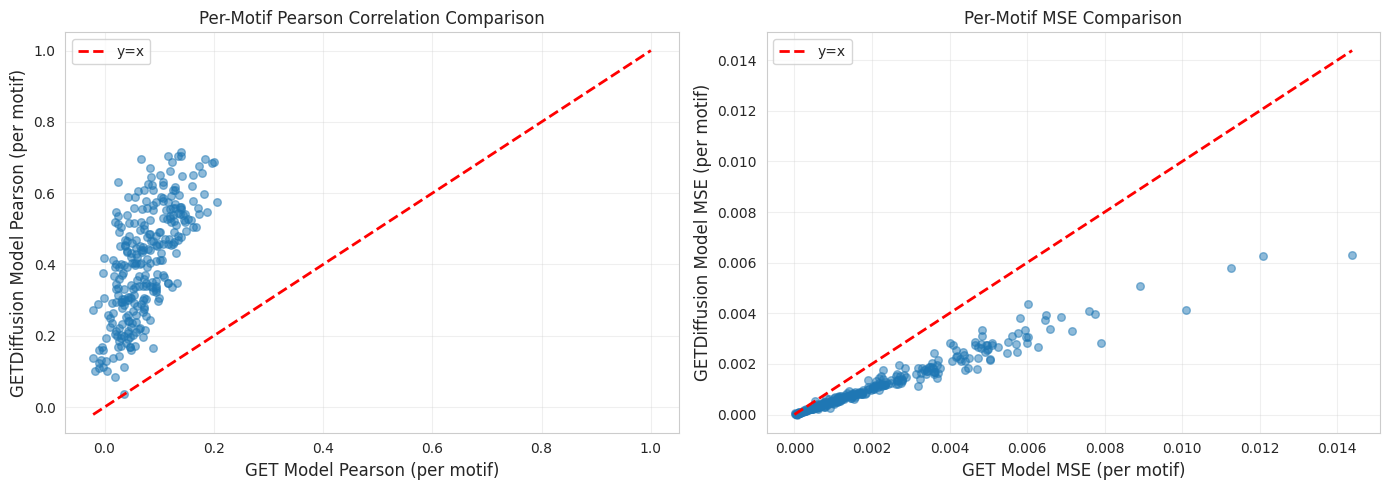


Per-motif comparison saved to results/per_motif_comparison.csv


In [80]:
# Create per-motif comparison plots (Pearson and MSE only)
if motif_metrics_diffusion is not None and motif_metrics_transformer is not None:
    fig, axes = plt.subplots(1, 2, figsize=(14, 5))
    
    # 1. Scatter: GET vs GETDiffusion Pearson correlation per motif
    ax = axes[0]
    ax.scatter(motif_metrics_transformer['pearson'], motif_metrics_diffusion['pearson'], 
               alpha=0.5, s=30)
    lims = [min(motif_metrics_transformer['pearson'].min(), motif_metrics_diffusion['pearson'].min()),
            max(motif_metrics_transformer['pearson'].max(), motif_metrics_diffusion['pearson'].max())]
    ax.plot(lims, lims, 'r--', linewidth=2, label='y=x')
    ax.set_xlabel('GET Model Pearson (per motif)', fontsize=12)
    ax.set_ylabel('GETDiffusion Model Pearson (per motif)', fontsize=12)
    ax.set_title('Per-Motif Pearson Correlation Comparison', fontsize=12)
    ax.legend()
    ax.grid(True, alpha=0.3)
    
    # 2. MSE comparison
    ax = axes[1]
    ax.scatter(motif_metrics_transformer['mse'], motif_metrics_diffusion['mse'], 
               alpha=0.5, s=30)
    lims = [min(motif_metrics_transformer['mse'].min(), motif_metrics_diffusion['mse'].min()),
            max(motif_metrics_transformer['mse'].max(), motif_metrics_diffusion['mse'].max())]
    ax.plot(lims, lims, 'r--', linewidth=2, label='y=x')
    ax.set_xlabel('GET Model MSE (per motif)', fontsize=12)
    ax.set_ylabel('GETDiffusion Model MSE (per motif)', fontsize=12)
    ax.set_title('Per-Motif MSE Comparison', fontsize=12)
    ax.legend()
    ax.grid(True, alpha=0.3)
    
    # plt.suptitle('Per-Motif Performance: GETDiffusion vs GET', fontsize=14, y=0.995)
    plt.tight_layout()
    plt.savefig(f'{RESULTS_DIR}/per_motif_comparison.png', dpi=150, bbox_inches='tight')
    plt.show()
    
    # Save per-motif comparison
    comparison_motif.to_csv(f'{RESULTS_DIR}/per_motif_comparison.csv', index=False)
    print(f'\nPer-motif comparison saved to {RESULTS_DIR}/per_motif_comparison.csv')
else:
    print("Cannot create per-motif comparison - need both models' predictions")


## Cell-Level Aggregation Analysis

Aggregate predictions at the cell level to see overall motif activity patterns.


In [74]:
def aggregate_cell_level(preds, obs, batch_indices, n_motifs=283):
    """
    Aggregate predictions per cell (batch) to get cell-level motif activity.
    Returns 2D arrays: (n_cells, n_motifs)
    """
    if preds.ndim == 1:
        return None
    
    # Flatten predictions to 2D if needed: (n_samples, n_motifs)
    if preds.ndim == 2:
        preds_flat = preds
        obs_flat = obs
    elif preds.ndim == 3:
        # Shape is (n_samples, n_regions, n_motifs) - average across regions to get (n_samples, n_motifs)
        preds_flat = preds.mean(axis=1)
        obs_flat = obs.mean(axis=1)
    else:
        # Flatten all but last dimension
        preds_flat = preds.reshape(-1, preds.shape[-1])
        obs_flat = obs.reshape(-1, obs.shape[-1])
    
    # Aggregate by batch
    unique_batches = np.unique(batch_indices)
    cell_preds = []
    cell_obs = []
    
    for batch_idx in unique_batches:
        mask = batch_indices == batch_idx
        if mask.sum() == 0:
            continue
        
        # Average across all samples in this batch/cell
        cell_pred = preds_flat[mask].mean(axis=0)  # Should be (n_motifs,)
        cell_obs_val = obs_flat[mask].mean(axis=0)
        
        cell_preds.append(cell_pred)
        cell_obs.append(cell_obs_val)
    
    cell_preds = np.array(cell_preds)  # Should be (n_cells, n_motifs)
    cell_obs = np.array(cell_obs)
    
    # Ensure 2D output
    if cell_preds.ndim == 1:
        cell_preds = cell_preds.reshape(1, -1)
        cell_obs = cell_obs.reshape(1, -1)
    
    return cell_preds, cell_obs


# Aggregate to cell level
if preds_diffusion_meta is not None and batch_idx_diff is not None:
    cell_preds_diffusion, cell_obs_diffusion = aggregate_cell_level(
        preds_diffusion_meta, obs_diffusion_meta, batch_idx_diff
    )
    if cell_preds_diffusion is not None:
        print(f"Diffusion Model - Cell-level aggregation:")
        print(f"  Number of cells: {len(cell_preds_diffusion)}")
        print(f"  Shape: {cell_preds_diffusion.shape}")
else:
    cell_preds_diffusion, cell_obs_diffusion = None, None

if preds_transformer_meta is not None and batch_idx_trans is not None:
    cell_preds_transformer, cell_obs_transformer = aggregate_cell_level(
        preds_transformer_meta, obs_transformer_meta, batch_idx_trans
    )
    if cell_preds_transformer is not None:
        print(f"\nTransformer Model - Cell-level aggregation:")
        print(f"  Number of cells: {len(cell_preds_transformer)}")
        print(f"  Shape: {cell_preds_transformer.shape}")
else:
    cell_preds_transformer, cell_obs_transformer = None, None

# Compute cell-level metrics
if cell_preds_diffusion is not None:
    cell_metrics_diffusion = compute_metrics(cell_preds_diffusion, cell_obs_diffusion)
    print(f"\nDiffusion Model - Cell-level metrics:")
    for k, v in cell_metrics_diffusion.items():
        if isinstance(v, float):
            print(f"  {k}: {v:.4f}")
        else:
            print(f"  {k}: {v}")

if cell_preds_transformer is not None:
    cell_metrics_transformer = compute_metrics(cell_preds_transformer, cell_obs_transformer)
    print(f"\nTransformer Model - Cell-level metrics:")
    for k, v in cell_metrics_transformer.items():
        if isinstance(v, float):
            print(f"  {k}: {v:.4f}")
        else:
            print(f"  {k}: {v}")


Diffusion Model - Cell-level aggregation:
  Number of cells: 79
  Shape: (79, 283)

Transformer Model - Cell-level aggregation:
  Number of cells: 5
  Shape: (5, 283)

Diffusion Model - Cell-level metrics:
  pearson: 0.9979785680770874
  spearman: 0.9846
  mse: 3.794772283072234e-06
  mae: 0.0012593150604516268
  r2: 0.9959
  n_samples: 22357

Transformer Model - Cell-level metrics:
  pearson: 0.9971290826797485
  spearman: 0.9746
  mse: 2.1647227185894735e-05
  mae: 0.003244988387450576
  r2: 0.9942
  n_samples: 1415


## Visualization: Cell-Level Predictions Heatmap


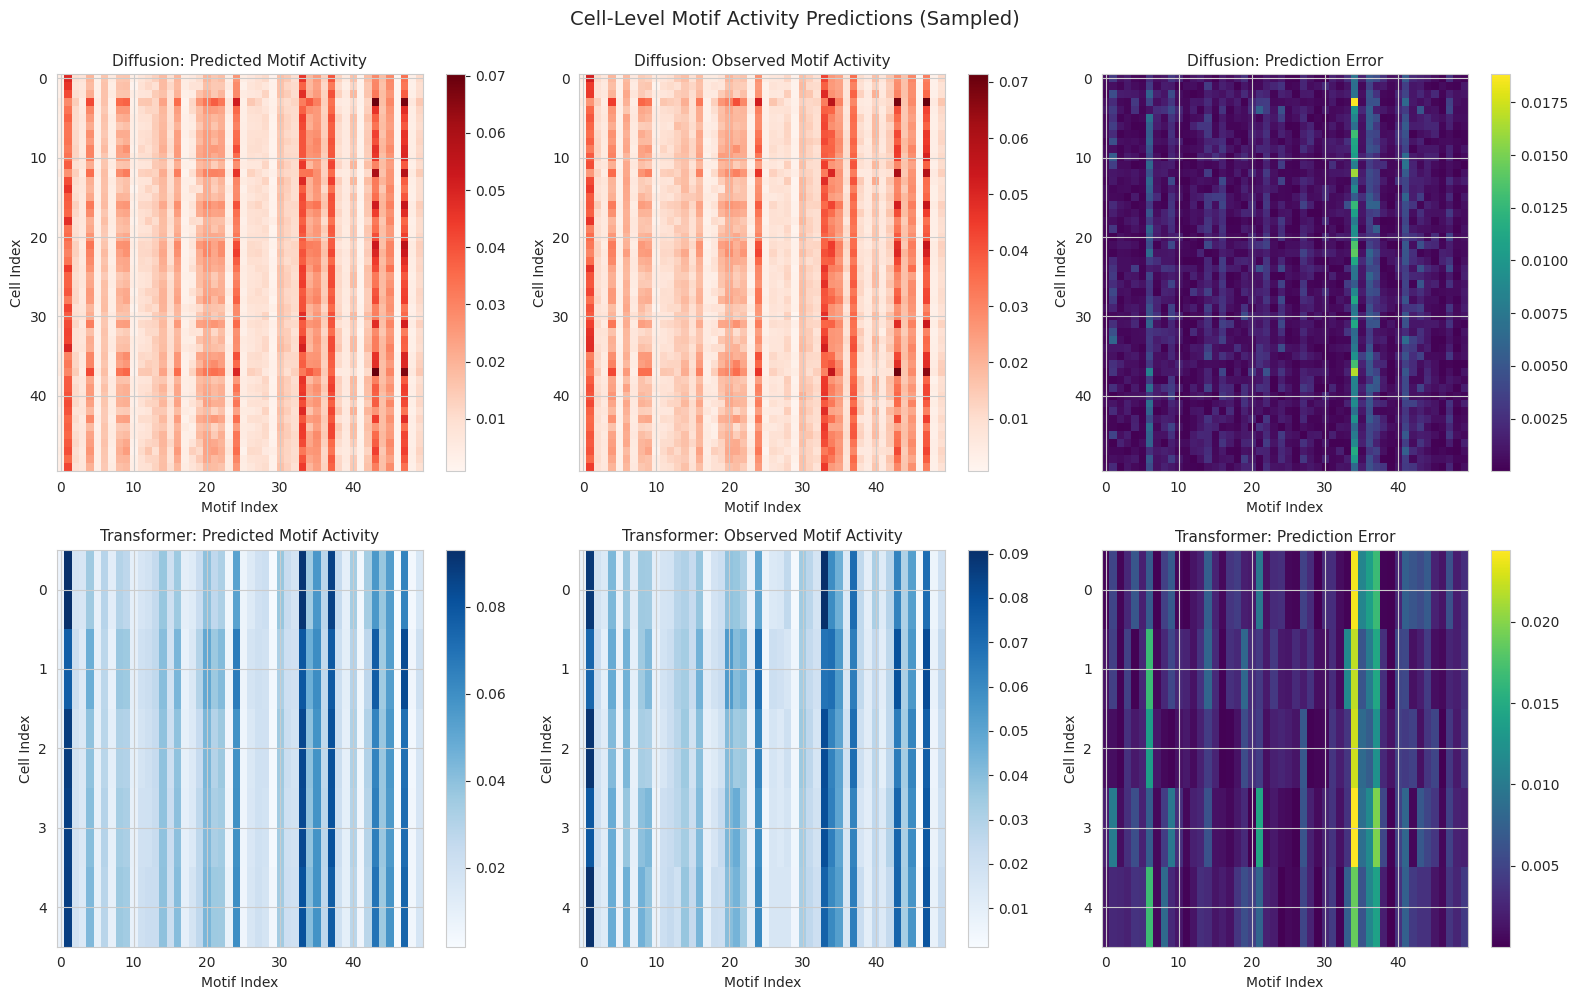

In [75]:
# Create heatmaps showing cell-level motif predictions
if cell_preds_diffusion is not None and cell_preds_transformer is not None:
    # Ensure 2D arrays
    if cell_preds_diffusion.ndim > 2:
        # If 3D, average across middle dimension to get (n_cells, n_motifs)
        cell_preds_diffusion = cell_preds_diffusion.mean(axis=1) if cell_preds_diffusion.ndim == 3 else cell_preds_diffusion.reshape(len(cell_preds_diffusion), -1)
        cell_obs_diffusion = cell_obs_diffusion.mean(axis=1) if cell_obs_diffusion.ndim == 3 else cell_obs_diffusion.reshape(len(cell_obs_diffusion), -1)
    
    if cell_preds_transformer.ndim > 2:
        cell_preds_transformer = cell_preds_transformer.mean(axis=1) if cell_preds_transformer.ndim == 3 else cell_preds_transformer.reshape(len(cell_preds_transformer), -1)
        cell_obs_transformer = cell_obs_transformer.mean(axis=1) if cell_obs_transformer.ndim == 3 else cell_obs_transformer.reshape(len(cell_obs_transformer), -1)
    
    # Sample cells and motifs for visualization (too many to show all)
    n_cells_show = min(50, len(cell_preds_diffusion))
    n_motifs_show = min(50, cell_preds_diffusion.shape[1])
    
    cell_indices = np.random.choice(len(cell_preds_diffusion), n_cells_show, replace=False)
    motif_indices = np.random.choice(cell_preds_diffusion.shape[1], n_motifs_show, replace=False)
    
    fig, axes = plt.subplots(2, 3, figsize=(16, 10))
    
    # Diffusion predictions
    ax = axes[0, 0]
    im = ax.imshow(cell_preds_diffusion[np.ix_(cell_indices, motif_indices)], 
                    aspect='auto', cmap='Reds', interpolation='nearest')
    ax.set_title('Diffusion: Predicted Motif Activity', fontsize=11)
    ax.set_xlabel('Motif Index')
    ax.set_ylabel('Cell Index')
    plt.colorbar(im, ax=ax)
    
    # Diffusion observations
    ax = axes[0, 1]
    im = ax.imshow(cell_obs_diffusion[np.ix_(cell_indices, motif_indices)], 
                    aspect='auto', cmap='Reds', interpolation='nearest')
    ax.set_title('Diffusion: Observed Motif Activity', fontsize=11)
    ax.set_xlabel('Motif Index')
    ax.set_ylabel('Cell Index')
    plt.colorbar(im, ax=ax)
    
    # Diffusion error
    ax = axes[0, 2]
    error_diff = np.abs(cell_preds_diffusion - cell_obs_diffusion)
    im = ax.imshow(error_diff[np.ix_(cell_indices, motif_indices)], 
                    aspect='auto', cmap='viridis', interpolation='nearest')
    ax.set_title('Diffusion: Prediction Error', fontsize=11)
    ax.set_xlabel('Motif Index')
    ax.set_ylabel('Cell Index')
    plt.colorbar(im, ax=ax)
    
    # Transformer predictions
    ax = axes[1, 0]
    # Match cell indices (may have different number of cells)
    trans_cell_indices = np.random.choice(len(cell_preds_transformer), 
                                          min(n_cells_show, len(cell_preds_transformer)), 
                                          replace=False)
    im = ax.imshow(cell_preds_transformer[np.ix_(trans_cell_indices, motif_indices)], 
                    aspect='auto', cmap='Blues', interpolation='nearest')
    ax.set_title('Transformer: Predicted Motif Activity', fontsize=11)
    ax.set_xlabel('Motif Index')
    ax.set_ylabel('Cell Index')
    plt.colorbar(im, ax=ax)
    
    # Transformer observations
    ax = axes[1, 1]
    im = ax.imshow(cell_obs_transformer[np.ix_(trans_cell_indices, motif_indices)], 
                    aspect='auto', cmap='Blues', interpolation='nearest')
    ax.set_title('Transformer: Observed Motif Activity', fontsize=11)
    ax.set_xlabel('Motif Index')
    ax.set_ylabel('Cell Index')
    plt.colorbar(im, ax=ax)
    
    # Transformer error
    ax = axes[1, 2]
    error_trans = np.abs(cell_preds_transformer - cell_obs_transformer)
    im = ax.imshow(error_trans[np.ix_(trans_cell_indices, motif_indices)], 
                    aspect='auto', cmap='viridis', interpolation='nearest')
    ax.set_title('Transformer: Prediction Error', fontsize=11)
    ax.set_xlabel('Motif Index')
    ax.set_ylabel('Cell Index')
    plt.colorbar(im, ax=ax)
    
    plt.suptitle('Cell-Level Motif Activity Predictions (Sampled)', fontsize=14, y=0.995)
    plt.tight_layout()
    plt.savefig(f'{RESULTS_DIR}/cell_level_heatmaps.png', dpi=150, bbox_inches='tight')
    plt.show()
else:
    print("Cannot create cell-level heatmaps - need both models' predictions")


## Per-Cell Performance Distribution

Compare the distribution of prediction quality across cells.


Diffusion Model - Per-cell correlation:
  Mean: 0.9980
  Median: 0.9980
  Std: 0.0003

Transformer Model - Per-cell correlation:
  Mean: 0.9971
  Median: 0.9972
  Std: 0.0001


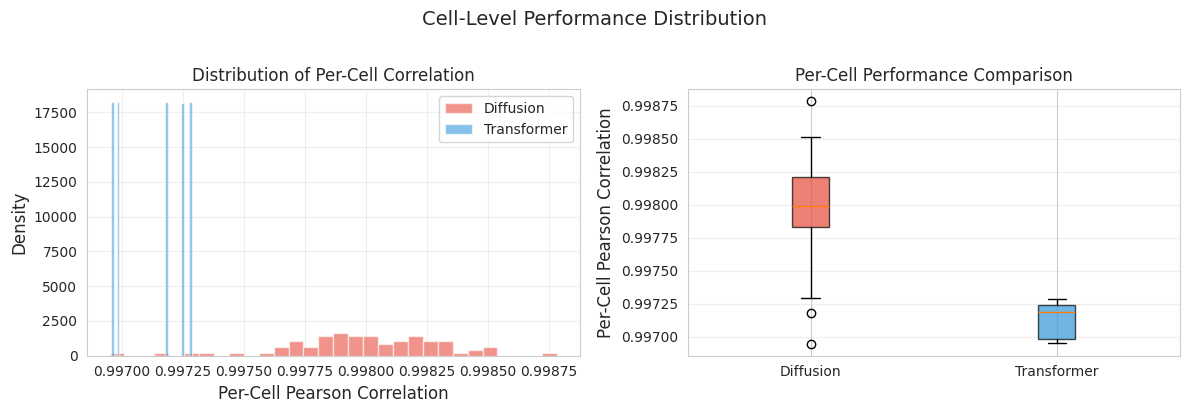


Mann-Whitney U test (per-cell correlation):
  Statistic: 387.00, p-value: 3.89e-06
  Significant difference (p < 0.05)


In [76]:
# Compute per-cell correlation
def compute_per_cell_correlation(preds, obs):
    """
    Compute Pearson correlation for each cell.
    """
    if preds.ndim == 1:
        return None
    
    per_cell_corr = []
    for i in range(len(preds)):
        p = preds[i].flatten()
        o = obs[i].flatten()
        valid = ~(np.isnan(p) | np.isnan(o))
        if valid.sum() < 2:
            per_cell_corr.append(np.nan)
        else:
            try:
                corr = stats.pearsonr(p[valid], o[valid])[0]
                per_cell_corr.append(corr)
            except:
                per_cell_corr.append(np.nan)
    
    return np.array(per_cell_corr)


if cell_preds_diffusion is not None:
    cell_corr_diffusion = compute_per_cell_correlation(cell_preds_diffusion, cell_obs_diffusion)
    print(f"Diffusion Model - Per-cell correlation:")
    print(f"  Mean: {np.nanmean(cell_corr_diffusion):.4f}")
    print(f"  Median: {np.nanmedian(cell_corr_diffusion):.4f}")
    print(f"  Std: {np.nanstd(cell_corr_diffusion):.4f}")
else:
    cell_corr_diffusion = None

if cell_preds_transformer is not None:
    cell_corr_transformer = compute_per_cell_correlation(cell_preds_transformer, cell_obs_transformer)
    print(f"\nTransformer Model - Per-cell correlation:")
    print(f"  Mean: {np.nanmean(cell_corr_transformer):.4f}")
    print(f"  Median: {np.nanmedian(cell_corr_transformer):.4f}")
    print(f"  Std: {np.nanstd(cell_corr_transformer):.4f}")
else:
    cell_corr_transformer = None

# Visualize per-cell performance distribution
if cell_corr_diffusion is not None and cell_corr_transformer is not None:
    fig, axes = plt.subplots(1, 2, figsize=(12, 4))
    
    # Histogram comparison
    ax = axes[0]
    ax.hist(cell_corr_diffusion[~np.isnan(cell_corr_diffusion)], bins=30, 
            alpha=0.6, label='Diffusion', color='#e74c3c', density=True)
    ax.hist(cell_corr_transformer[~np.isnan(cell_corr_transformer)], bins=30, 
            alpha=0.6, label='Transformer', color='#3498db', density=True)
    ax.set_xlabel('Per-Cell Pearson Correlation', fontsize=12)
    ax.set_ylabel('Density', fontsize=12)
    ax.set_title('Distribution of Per-Cell Correlation', fontsize=12)
    ax.legend()
    ax.grid(True, alpha=0.3)
    
    # Box plot comparison
    ax = axes[1]
    data_to_plot = [
        cell_corr_diffusion[~np.isnan(cell_corr_diffusion)],
        cell_corr_transformer[~np.isnan(cell_corr_transformer)]
    ]
    bp = ax.boxplot(data_to_plot, labels=['Diffusion', 'Transformer'], patch_artist=True)
    bp['boxes'][0].set_facecolor('#e74c3c')
    bp['boxes'][1].set_facecolor('#3498db')
    for patch in bp['boxes']:
        patch.set_alpha(0.7)
    ax.set_ylabel('Per-Cell Pearson Correlation', fontsize=12)
    ax.set_title('Per-Cell Performance Comparison', fontsize=12)
    ax.grid(True, alpha=0.3, axis='y')
    
    plt.suptitle('Cell-Level Performance Distribution', fontsize=14, y=1.02)
    plt.tight_layout()
    plt.savefig(f'{RESULTS_DIR}/per_cell_performance.png', dpi=150, bbox_inches='tight')
    plt.show()
    
    # Statistical test
    from scipy.stats import mannwhitneyu
    try:
        stat, pval = mannwhitneyu(
            cell_corr_diffusion[~np.isnan(cell_corr_diffusion)],
            cell_corr_transformer[~np.isnan(cell_corr_transformer)],
            alternative='two-sided'
        )
        print(f"\nMann-Whitney U test (per-cell correlation):")
        print(f"  Statistic: {stat:.2f}, p-value: {pval:.2e}")
        if pval < 0.05:
            print(f"  Significant difference (p < 0.05)")
        else:
            print(f"  No significant difference (p >= 0.05)")
    except Exception as e:
        print(f"Could not perform statistical test: {e}")


## Top/Bottom Performing Motifs Analysis

Identify which motifs are predicted best and worst by each model.


TOP PERFORMING MOTIFS

Diffusion Model - Top 10 motifs (by Pearson):
 motif_idx  pearson          mse
       282 0.999988 5.989058e-07
       140 0.718302 4.097710e-04
       186 0.716517 7.719602e-04
       136 0.703036 6.166988e-04
       233 0.700879 1.181449e-03
        75 0.694695 1.014120e-03
        37 0.693210 2.219794e-03
        34 0.687503 4.750952e-04
       135 0.686648 1.017237e-03
        38 0.682820 5.982436e-04

Transformer Model - Top 10 motifs (by Pearson):
 motif_idx  pearson      mse
        34 0.235654 0.000780
        38 0.202980 0.001146
       249 0.200228 0.001398
       226 0.197548 0.002791
        37 0.197457 0.004374
       141 0.196867 0.004201
        54 0.196834 0.001160
       213 0.186249 0.005652
       146 0.182633 0.000153
       170 0.180619 0.003250

BOTTOM PERFORMING MOTIFS

Diffusion Model - Bottom 10 motifs (by Pearson):
 motif_idx  pearson      mse
        63 0.039225 0.000030
       218 0.087243 0.000365
       196 0.101181 0.000626
        

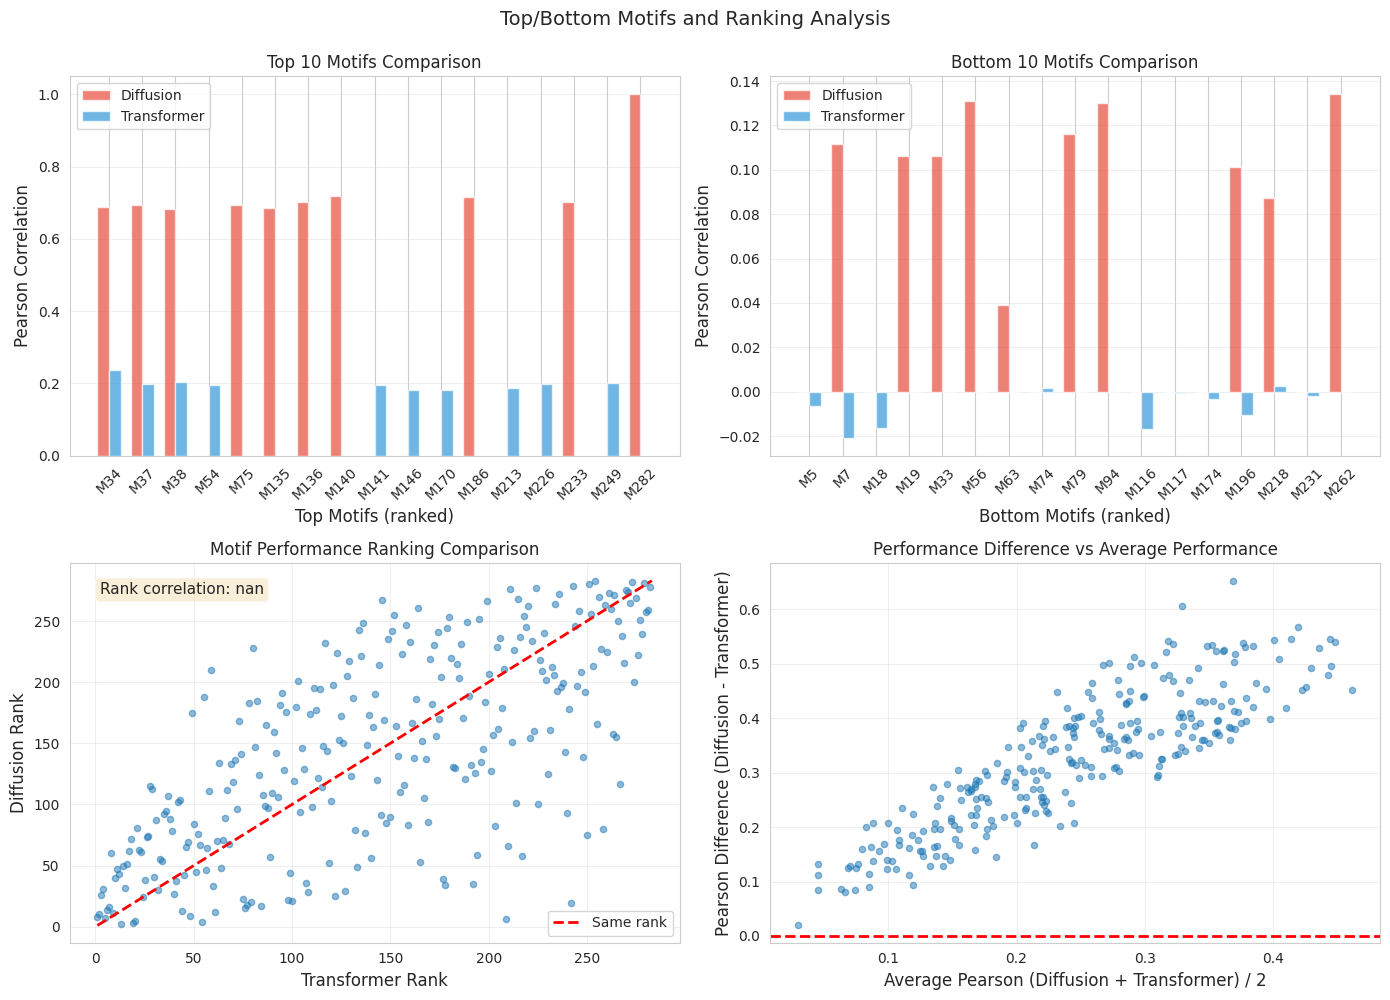

In [24]:
# Identify top and bottom performing motifs
if motif_metrics_diffusion is not None and motif_metrics_transformer is not None:
    n_top = 10
    
    # Top performing motifs for each model
    top_diffusion = motif_metrics_diffusion.nlargest(n_top, 'pearson')
    top_transformer = motif_metrics_transformer.nlargest(n_top, 'pearson')
    
    # Bottom performing motifs
    bottom_diffusion = motif_metrics_diffusion.nsmallest(n_top, 'pearson')
    bottom_transformer = motif_metrics_transformer.nsmallest(n_top, 'pearson')
    
    print("="*70)
    print("TOP PERFORMING MOTIFS")
    print("="*70)
    print(f"\nDiffusion Model - Top {n_top} motifs (by Pearson):")
    print(top_diffusion[['motif_idx', 'pearson', 'mse']].to_string(index=False))
    
    print(f"\nTransformer Model - Top {n_top} motifs (by Pearson):")
    print(top_transformer[['motif_idx', 'pearson', 'mse']].to_string(index=False))
    
    print("\n" + "="*70)
    print("BOTTOM PERFORMING MOTIFS")
    print("="*70)
    print(f"\nDiffusion Model - Bottom {n_top} motifs (by Pearson):")
    print(bottom_diffusion[['motif_idx', 'pearson', 'mse']].to_string(index=False))
    
    print(f"\nTransformer Model - Bottom {n_top} motifs (by Pearson):")
    print(bottom_transformer[['motif_idx', 'pearson', 'mse']].to_string(index=False))
    
    # Visualize top/bottom motifs
    fig, axes = plt.subplots(2, 2, figsize=(14, 10))
    
    # Top motifs comparison
    ax = axes[0, 0]
    top_motifs_merged = pd.merge(
        top_diffusion[['motif_idx', 'pearson']].rename(columns={'pearson': 'diffusion'}),
        top_transformer[['motif_idx', 'pearson']].rename(columns={'pearson': 'transformer'}),
        on='motif_idx',
        how='outer'
    ).fillna(0)
    x_pos = np.arange(len(top_motifs_merged))
    width = 0.35
    ax.bar(x_pos - width/2, top_motifs_merged['diffusion'], width, 
           label='Diffusion', color='#e74c3c', alpha=0.7)
    ax.bar(x_pos + width/2, top_motifs_merged['transformer'], width, 
           label='Transformer', color='#3498db', alpha=0.7)
    ax.set_xlabel('Top Motifs (ranked)', fontsize=12)
    ax.set_ylabel('Pearson Correlation', fontsize=12)
    ax.set_title(f'Top {n_top} Motifs Comparison', fontsize=12)
    ax.set_xticks(x_pos)
    ax.set_xticklabels([f"M{int(idx)}" for idx in top_motifs_merged['motif_idx']], rotation=45)
    ax.legend()
    ax.grid(True, alpha=0.3, axis='y')
    
    # Bottom motifs comparison
    ax = axes[0, 1]
    bottom_motifs_merged = pd.merge(
        bottom_diffusion[['motif_idx', 'pearson']].rename(columns={'pearson': 'diffusion'}),
        bottom_transformer[['motif_idx', 'pearson']].rename(columns={'pearson': 'transformer'}),
        on='motif_idx',
        how='outer'
    ).fillna(0)
    x_pos = np.arange(len(bottom_motifs_merged))
    ax.bar(x_pos - width/2, bottom_motifs_merged['diffusion'], width, 
           label='Diffusion', color='#e74c3c', alpha=0.7)
    ax.bar(x_pos + width/2, bottom_motifs_merged['transformer'], width, 
           label='Transformer', color='#3498db', alpha=0.7)
    ax.set_xlabel('Bottom Motifs (ranked)', fontsize=12)
    ax.set_ylabel('Pearson Correlation', fontsize=12)
    ax.set_title(f'Bottom {n_top} Motifs Comparison', fontsize=12)
    ax.set_xticks(x_pos)
    ax.set_xticklabels([f"M{int(idx)}" for idx in bottom_motifs_merged['motif_idx']], rotation=45)
    ax.legend()
    ax.grid(True, alpha=0.3, axis='y')
    
    # Rank comparison scatter
    ax = axes[1, 0]
    # Rank motifs by performance
    motif_metrics_diffusion['rank'] = motif_metrics_diffusion['pearson'].rank(ascending=False)
    motif_metrics_transformer['rank'] = motif_metrics_transformer['pearson'].rank(ascending=False)
    rank_merged = pd.merge(
        motif_metrics_diffusion[['motif_idx', 'rank']].rename(columns={'rank': 'diffusion_rank'}),
        motif_metrics_transformer[['motif_idx', 'rank']].rename(columns={'rank': 'transformer_rank'}),
        on='motif_idx'
    )
    ax.scatter(rank_merged['transformer_rank'], rank_merged['diffusion_rank'], 
               alpha=0.5, s=20)
    lims = [min(rank_merged['transformer_rank'].min(), rank_merged['diffusion_rank'].min()),
            max(rank_merged['transformer_rank'].max(), rank_merged['diffusion_rank'].max())]
    ax.plot(lims, lims, 'r--', linewidth=2, label='Same rank')
    ax.set_xlabel('Transformer Rank', fontsize=12)
    ax.set_ylabel('Diffusion Rank', fontsize=12)
    ax.set_title('Motif Performance Ranking Comparison', fontsize=12)
    ax.legend()
    ax.grid(True, alpha=0.3)
    
    # Correlation of ranks
    rank_corr = stats.spearmanr(rank_merged['diffusion_rank'], rank_merged['transformer_rank'])[0]
    ax.text(0.05, 0.95, f'Rank correlation: {rank_corr:.3f}', 
            transform=ax.transAxes, fontsize=11, verticalalignment='top',
            bbox=dict(boxstyle='round', facecolor='wheat', alpha=0.5))
    
    # Performance difference vs average performance
    ax = axes[1, 1]
    comparison_motif['avg_pearson'] = (comparison_motif['pearson_diffusion'] + 
                                       comparison_motif['pearson_transformer']) / 2
    ax.scatter(comparison_motif['avg_pearson'], comparison_motif['pearson_diff'], 
               alpha=0.5, s=20)
    ax.axhline(y=0, color='red', linestyle='--', linewidth=2)
    ax.set_xlabel('Average Pearson (Diffusion + Transformer) / 2', fontsize=12)
    ax.set_ylabel('Pearson Difference (Diffusion - Transformer)', fontsize=12)
    ax.set_title('Performance Difference vs Average Performance', fontsize=12)
    ax.grid(True, alpha=0.3)
    
    plt.suptitle('Top/Bottom Motifs and Ranking Analysis', fontsize=14, y=0.995)
    plt.tight_layout()
    plt.savefig(f'{RESULTS_DIR}/top_bottom_motifs_analysis.png', dpi=150, bbox_inches='tight')
    plt.show()
else:
    print("Cannot analyze top/bottom motifs - need both models' per-motif metrics")


## Training Loss Comparison Over Epochs

Compare training and validation loss curves between GETDiffusion and GET models.


In [35]:
# Load CSV log files from ~/greatlakes directory
import glob

# Log files are in ~/greatlakes directory
greatlakes_dir = os.path.expanduser("~/greatlakes")

# Direct paths to the CSV log files
diffusion_log_path = os.path.join(greatlakes_dir, "GETDiffusion", "metrics.csv")
transformer_log_path = os.path.join(greatlakes_dir, "GET", "metrics.csv")

print(f"GETDiffusion log path: {diffusion_log_path}")
print(f"GETDiffusion log exists: {os.path.exists(diffusion_log_path)}")
print(f"\nGET log path: {transformer_log_path}")
print(f"GET log exists: {os.path.exists(transformer_log_path)}")

# If not found, try to search in greatlakes directory
if not os.path.exists(diffusion_log_path) or not os.path.exists(transformer_log_path):
    print("\nSearching for CSV log files in ~/greatlakes...")
    csv_files = glob.glob(os.path.join(greatlakes_dir, "**", "*.csv"), recursive=True)
    print(f"Found {len(csv_files)} CSV files:")
    for f in csv_files[:10]:  # Show first 10
        print(f"  {f}")


GETDiffusion log path: /home/yoyomanzoor/greatlakes/GETDiffusion/metrics.csv
GETDiffusion log exists: True

GET log path: /home/yoyomanzoor/greatlakes/GET/metrics.csv
GET log exists: True


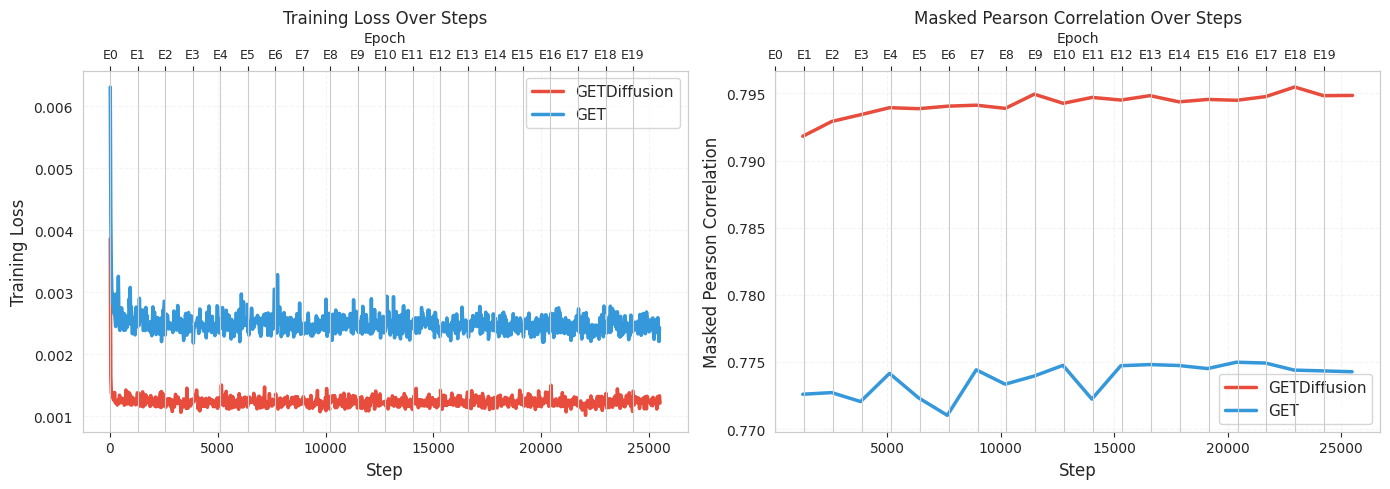


TRAINING SUMMARY

GETDiffusion - Final Training Loss: nan
GETDiffusion - Minimum Training Loss: 0.001018
GET - Final Training Loss: nan
GET - Minimum Training Loss: 0.002182

GETDiffusion - Final Masked Pearson: 0.794850
GETDiffusion - Maximum Masked Pearson: 0.795476
GET - Final Masked Pearson: 0.774272
GET - Maximum Masked Pearson: 0.774981


In [81]:
# Load and plot training loss curves
if diffusion_log_path and os.path.exists(diffusion_log_path) and transformer_log_path and os.path.exists(transformer_log_path):
    # Load CSV logs
    df_diffusion = pd.read_csv(diffusion_log_path)
    df_transformer = pd.read_csv(transformer_log_path)
    
    # Create figure with subplots
    fig, axes = plt.subplots(1, 2, figsize=(14, 5))
    
    # Plot training loss by step
    ax = axes[0]
    if 'step' in df_diffusion.columns and 'train_loss' in df_diffusion.columns:
        ax.plot(df_diffusion['step'], df_diffusion['train_loss'], 
                label='GETDiffusion', color='#e74c3c', linewidth=2.5)
    if 'step' in df_transformer.columns and 'train_loss' in df_transformer.columns:
        ax.plot(df_transformer['step'], df_transformer['train_loss'], 
                label='GET', color='#3498db', linewidth=2.5)
    ax.set_xlabel('Step', fontsize=12)
    ax.set_ylabel('Training Loss', fontsize=12)
    ax.set_title('Training Loss Over Steps', fontsize=12)
    ax.legend(fontsize=11)
    ax.grid(True, alpha=0.2, linestyle='--')
    
    # Add epoch labels on secondary x-axis (use diffusion model for epoch markers)
    if 'epoch' in df_diffusion.columns and 'step' in df_diffusion.columns:
        # Get unique epochs and their corresponding step values
        epoch_steps = df_diffusion[df_diffusion['epoch'].notna()].groupby('epoch')['step'].first()
        if len(epoch_steps) > 0:
            ax2 = ax.twiny()
            ax2.set_xlim(ax.get_xlim())
            ax2.set_xticks(epoch_steps.values)
            ax2.set_xticklabels([f'E{int(e)}' for e in epoch_steps.index], fontsize=9)
            ax2.set_xlabel('Epoch', fontsize=10)
    
    # Plot masked_pearson by step
    ax = axes[1]
    if 'step' in df_diffusion.columns and 'masked_pearson' in df_diffusion.columns:
        # Filter out NaN values
        df_diff_pearson = df_diffusion[df_diffusion['masked_pearson'].notna()]
        if len(df_diff_pearson) > 0:
            ax.plot(df_diff_pearson['step'], df_diff_pearson['masked_pearson'], 
                    label='GETDiffusion', color='#e74c3c', linewidth=2.5)
    if 'step' in df_transformer.columns and 'masked_pearson' in df_transformer.columns:
        # Filter out NaN values
        df_trans_pearson = df_transformer[df_transformer['masked_pearson'].notna()]
        if len(df_trans_pearson) > 0:
            ax.plot(df_trans_pearson['step'], df_trans_pearson['masked_pearson'], 
                    label='GET', color='#3498db', linewidth=2.5)
    ax.set_xlabel('Step', fontsize=12)
    ax.set_ylabel('Masked Pearson Correlation', fontsize=12)
    ax.set_title('Masked Pearson Correlation Over Steps', fontsize=12)
    ax.legend(fontsize=11)
    ax.grid(True, alpha=0.2, linestyle='--')
    
    # Add epoch labels on secondary x-axis (use diffusion model for epoch markers)
    if 'epoch' in df_diffusion.columns and 'step' in df_diffusion.columns:
        # Get unique epochs and their corresponding step values
        epoch_steps = df_diffusion[df_diffusion['epoch'].notna()].groupby('epoch')['step'].first()
        if len(epoch_steps) > 0:
            ax2 = ax.twiny()
            ax2.set_xlim(ax.get_xlim())
            ax2.set_xticks(epoch_steps.values)
            ax2.set_xticklabels([f'E{int(e)}' for e in epoch_steps.index], fontsize=9)
            ax2.set_xlabel('Epoch', fontsize=10)
    
    # plt.suptitle('Training Loss and Pearson Correlation: GETDiffusion vs GET', fontsize=14, y=1.02)
    plt.tight_layout()
    plt.savefig(f'{RESULTS_DIR}/training_loss_comparison.png', dpi=150, bbox_inches='tight')
    plt.show()
    
    # Print summary statistics
    print("\n" + "="*70)
    print("TRAINING SUMMARY")
    print("="*70)
    if 'train_loss' in df_diffusion.columns:
        print(f"\nGETDiffusion - Final Training Loss: {df_diffusion['train_loss'].iloc[-1]:.6f}")
        print(f"GETDiffusion - Minimum Training Loss: {df_diffusion['train_loss'].min():.6f}")
    if 'train_loss' in df_transformer.columns:
        print(f"GET - Final Training Loss: {df_transformer['train_loss'].iloc[-1]:.6f}")
        print(f"GET - Minimum Training Loss: {df_transformer['train_loss'].min():.6f}")
    if 'masked_pearson' in df_diffusion.columns:
        df_diff_pearson = df_diffusion[df_diffusion['masked_pearson'].notna()]
        if len(df_diff_pearson) > 0:
            print(f"\nGETDiffusion - Final Masked Pearson: {df_diff_pearson['masked_pearson'].iloc[-1]:.6f}")
            print(f"GETDiffusion - Maximum Masked Pearson: {df_diff_pearson['masked_pearson'].max():.6f}")
    if 'masked_pearson' in df_transformer.columns:
        df_trans_pearson = df_transformer[df_transformer['masked_pearson'].notna()]
        if len(df_trans_pearson) > 0:
            print(f"GET - Final Masked Pearson: {df_trans_pearson['masked_pearson'].iloc[-1]:.6f}")
            print(f"GET - Maximum Masked Pearson: {df_trans_pearson['masked_pearson'].max():.6f}")
        
elif diffusion_log_path and os.path.exists(diffusion_log_path):
    print("Found GETDiffusion logs but not GET logs. Plotting GETDiffusion only...")
    df_diffusion = pd.read_csv(diffusion_log_path)
    
    fig, axes = plt.subplots(1, 2, figsize=(14, 5))
    
    # Plot training loss by step
    ax = axes[0]
    if 'step' in df_diffusion.columns and 'train_loss' in df_diffusion.columns:
        ax.plot(df_diffusion['step'], df_diffusion['train_loss'], 
                label='GETDiffusion', color='#e74c3c', linewidth=2.5)
    ax.set_xlabel('Step', fontsize=12)
    ax.set_ylabel('Training Loss', fontsize=12)
    ax.set_title('Training Loss Over Steps (GETDiffusion)', fontsize=12)
    ax.legend(fontsize=11)
    ax.grid(True, alpha=0.2, linestyle='--')
    
    # Add epoch labels on secondary x-axis
    if 'epoch' in df_diffusion.columns and 'step' in df_diffusion.columns:
        epoch_steps = df_diffusion[df_diffusion['epoch'].notna()].groupby('epoch')['step'].first()
        if len(epoch_steps) > 0:
            ax2 = ax.twiny()
            ax2.set_xlim(ax.get_xlim())
            ax2.set_xticks(epoch_steps.values)
            ax2.set_xticklabels([f'E{int(e)}' for e in epoch_steps.index], fontsize=9)
            ax2.set_xlabel('Epoch', fontsize=10)
    
    # Plot masked_pearson by step
    ax = axes[1]
    if 'step' in df_diffusion.columns and 'masked_pearson' in df_diffusion.columns:
        df_diff_pearson = df_diffusion[df_diffusion['masked_pearson'].notna()]
        if len(df_diff_pearson) > 0:
            ax.plot(df_diff_pearson['step'], df_diff_pearson['masked_pearson'], 
                    label='GETDiffusion', color='#e74c3c', linewidth=2.5)
    ax.set_xlabel('Step', fontsize=12)
    ax.set_ylabel('Masked Pearson Correlation', fontsize=12)
    ax.set_title('Masked Pearson Correlation Over Steps (GETDiffusion)', fontsize=12)
    ax.legend(fontsize=11)
    ax.grid(True, alpha=0.2, linestyle='--')
    
    # Add epoch labels on secondary x-axis
    if 'epoch' in df_diffusion.columns and 'step' in df_diffusion.columns:
        epoch_steps = df_diffusion[df_diffusion['epoch'].notna()].groupby('epoch')['step'].first()
        if len(epoch_steps) > 0:
            ax2 = ax.twiny()
            ax2.set_xlim(ax.get_xlim())
            ax2.set_xticks(epoch_steps.values)
            ax2.set_xticklabels([f'E{int(e)}' for e in epoch_steps.index], fontsize=9)
            ax2.set_xlabel('Epoch', fontsize=10)
    
    plt.suptitle('Training Loss and Pearson Correlation: GETDiffusion', fontsize=14, y=1.02)
    plt.tight_layout()
    plt.savefig(f'{RESULTS_DIR}/training_loss_getdiffusion.png', dpi=150, bbox_inches='tight')
    plt.show()
    
else:
    print("CSV log files not found. Please check the log file paths above.")
    print("\nTo generate this plot, ensure CSV log files exist at:")
    print(f"  - GETDiffusion: {diffusion_log_path}")
    print(f"  - GET: Check transformer run name in output directory")
    print("\nAlternatively, you can manually specify the paths to the CSV log files.")


## Summary Statistics Table

Create a comprehensive summary table of all metrics.


In [77]:
# Create comprehensive summary
summary_data = []

if metrics_diffusion is not None:
    summary_data.append({
        'Model': 'Diffusion',
        'Level': 'Overall',
        'Pearson': metrics_diffusion['pearson'],
        'Spearman': metrics_diffusion['spearman'],
        'MSE': metrics_diffusion['mse'],
        'R²': metrics_diffusion['r2'],
        'N Samples': metrics_diffusion['n_samples']
    })
    
    if motif_metrics_diffusion is not None:
        summary_data.append({
            'Model': 'Diffusion',
            'Level': 'Per-Motif (mean)',
            'Pearson': motif_metrics_diffusion['pearson'].mean(),
            'Spearman': motif_metrics_diffusion['spearman'].mean(),
            'MSE': motif_metrics_diffusion['mse'].mean(),
            'R²': np.nan,
            'N Samples': len(motif_metrics_diffusion)
        })
    
    if cell_metrics_diffusion is not None:
        summary_data.append({
            'Model': 'Diffusion',
            'Level': 'Per-Cell (mean)',
            'Pearson': cell_metrics_diffusion['pearson'],
            'Spearman': cell_metrics_diffusion['spearman'],
            'MSE': cell_metrics_diffusion['mse'],
            'R²': cell_metrics_diffusion['r2'],
            'N Samples': cell_metrics_diffusion['n_samples']
        })

if metrics_transformer is not None:
    summary_data.append({
        'Model': 'Transformer',
        'Level': 'Overall',
        'Pearson': metrics_transformer['pearson'],
        'Spearman': metrics_transformer['spearman'],
        'MSE': metrics_transformer['mse'],
        'R²': metrics_transformer['r2'],
        'N Samples': metrics_transformer['n_samples']
    })
    
    if motif_metrics_transformer is not None:
        summary_data.append({
            'Model': 'Transformer',
            'Level': 'Per-Motif (mean)',
            'Pearson': motif_metrics_transformer['pearson'].mean(),
            'Spearman': motif_metrics_transformer['spearman'].mean(),
            'MSE': motif_metrics_transformer['mse'].mean(),
            'R²': np.nan,
            'N Samples': len(motif_metrics_transformer)
        })
    
    if cell_metrics_transformer is not None:
        summary_data.append({
            'Model': 'Transformer',
            'Level': 'Per-Cell (mean)',
            'Pearson': cell_metrics_transformer['pearson'],
            'Spearman': cell_metrics_transformer['spearman'],
            'MSE': cell_metrics_transformer['mse'],
            'R²': cell_metrics_transformer['r2'],
            'N Samples': cell_metrics_transformer['n_samples']
        })

if summary_data:
    summary_df = pd.DataFrame(summary_data)
    print("\n" + "="*80)
    print("COMPREHENSIVE SUMMARY STATISTICS")
    print("="*80)
    display(summary_df)
    
    # Save summary
    summary_df.to_csv(f'{RESULTS_DIR}/comprehensive_summary.csv', index=False)
    print(f'\nSummary saved to {RESULTS_DIR}/comprehensive_summary.csv')



COMPREHENSIVE SUMMARY STATISTICS


,Model,Level,Pearson,Spearman,MSE,R²,N Samples
0,Diffusion,Overall,0.796029,0.588960,0.001251,0.631310,35771200
1,Diffusion,Per-Motif (mean),0.407314,0.488431,0.001245,NaN,283
2,Diffusion,Per-Cell (mean),0.997979,0.984630,0.000004,0.995929,22357
3,Transformer,Overall,0.779998,0.381709,0.002377,0.608295,1153225
4,Transformer,Per-Motif (mean),0.073874,0.075629,0.002376,NaN,283
5,Transformer,Per-Cell (mean),0.997129,0.974551,0.000022,0.994157,1415



Summary saved to results/comprehensive_summary.csv
